# Plot the figures for the control points algorithms

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### a) Differential evolution

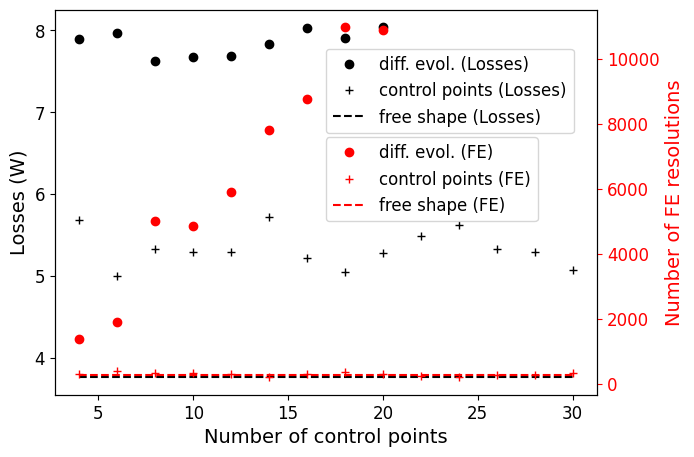

In [26]:
NControlPointsDE = np.arange(4,21,2)
LossFinalDE = []
InductanceFinalDE = []
NFEMFinalDE = []
for iN in range(len(NControlPointsDE)):
    filename = "results/differential_evolution_N"+ str(NControlPointsDE[iN]) +".pkl"
    with open(filename, "rb") as input_file:
        res = pickle.load(input_file)
    LossFinalDE.append(res["lossOpt"])
    InductanceFinalDE.append(res["inductanceOpt"])
    NFEMFinalDE.append(res["FEMcounter"])

plt.subplots(figsize=(7, 5))
ax1 = plt.plot(NControlPointsDE,LossFinalDE, 'o', color="k", label = 'diff. evol. (Losses)')
plt.ylabel("Losses (W)", color="k")
plt.xlabel("Number of control points")



## Gradient
NControlPointsGrad = np.arange(4,31,2)
LossFinalGrad = []
InductanceFinalGrad = []
NFEMFinalGrad = []
for iN in range(len(NControlPointsGrad)):
    filename = "results/gradient_based_N"+ str(NControlPointsGrad[iN]) +".pkl"
    with open(filename, "rb") as input_file:
        res = pickle.load(input_file)
    LossFinalGrad.append(res["LossList"][-1])
    InductanceFinalGrad.append(res["InductanceList"][-1])
    NFEMFinalGrad.append(res["NFEM"])

plt.plot(NControlPointsGrad,LossFinalGrad, '+', color="k", label = 'control points (Losses)')
plt.plot([4,30],[3.76, 3.76], '--', color="k", label = 'free shape (Losses)')


plt.legend(loc=(0.5,0.68))
ax2 = plt.gca().twinx()
ax2.plot(NControlPointsDE, NFEMFinalDE, 'o', color="r", label = 'diff. evol. (FE)')
plt.ylabel("Number of FE resolutions", color="r")
ax2.plot(NControlPointsGrad, NFEMFinalGrad, '+', color="r", label = 'control points (FE)')
ax2.plot([4,30],[277, 277], '--', color="r", label = 'free shape (FE)')

ax2.tick_params(axis='y', colors='red')
plt.legend(loc=(0.5,0.45))
plt.savefig("DEvsGrad.pdf", format="pdf", bbox_inches="tight")

plt.show()



In [25]:
np.mean(LossFinalDE)

np.float64(7.851157390967308)

### b) Gradient-based

In [3]:
filename = "results/differential_evolution_N"+ str(10) +".pkl"
with open(filename, "rb") as input_file:
        res = pickle.load(input_file)

In [4]:
res.keys()

dict_keys(['xList', 'LossList', 'FEMcounter', 'objCounter', 'xOpt', 'lossOpt', 'inductanceOpt', 'mesh'])

## 1 - Geometry and meshing

We define a geometry with an arbitrary number of control points on the airgap.

In [5]:
NControlPoints = 10
airgap = [1e-3,2e-3]*(NControlPoints//2)
lz = 1e-2  # thickness in the z-direction (m)
s = 4  # symmetry factor

maxh = 4e-3
mesh, _, _ = gen_meshN(airgap, maxh)

XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

materialFunction = 1 * XiAir + 2 * XiCoil + 3 * XiCore
Draw(materialFunction, mesh, radius=0.02)


NameError: name 'gen_meshN' is not defined

## 2 - State problem

### a) Parameters definition

In [ ]:
f = 5e4  # working frequency (Hz)
omega = 2 * np.pi * f  # rad/s
mu0 = 4e-7 * np.pi  # void permeability (H/m)
mur = 1000  # relative permeability of iron (no unit)
mu_iron = mur * mu0  # permeability of iron (H/m)
delta = 0.1  # loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0  # complex permeability
nb_turn = 200  # number of turn in the coil (no unit)
Is = 2  # source current intensity (A)
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # source current density (A/m²)


### b) Definition of the magnetic problem

In [ ]:
def magWeakFormComplex(a, a_):
    """Return the complex weak form of the magnetic problem, i.e, bilinear
    and linear forms (matrix and right-hand side after discretization, respectively)"""

    # bilinear form (transmission)
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")

    # linear form (source)
    lf = a_ * js * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh):
    """Solve the complex magnetic state"""
    # definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()

    # definition of weak form
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f

    # assembly
    K.Assemble()
    F.Assemble()

    # solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec

    return gf


### c) Definition of the post-processed quantities

We define the losses and inductance. We don't need derivatives here since we'll use a differential evolution algorithm, which is a gradient-free optimization algorithm.

In [ ]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


## 3 - Optimization

### a) Scipy wrapper
We first define wrappers of the objective function to minimize (the losses) and the constraint (the inductance value). We have to set a tolerance for the equality constraint, that we chose to be $\pm5\%$.

In [ ]:
# FEM evaluation counter (solve the FEM system)
FEMcounter = [0]
LossList = []
xList = []


def scipyObj(x, maxh = 4e-3):
    """ Scipy wrapper to the objective function to minimize """
    FEMcounter[0] += 1                      # Increment at each evaluation
    if FEMcounter[0] % 100 == 0:            # print every 100 function calls
        print(f"{FEMcounter[0]} function evaluations")
    mesh, _, _ = gen_meshN(list(x), maxh)
    a = solveStateComplex(mesh)
    return Losses(a, mesh)

def scipyConst(x, maxh = 4e-3):
    """ Scipy wrapper to the constraint to respect """
    FEMcounter[0] += 1                      # Increment at each evaluation
    if FEMcounter[0] % 100 == 0:            # print every 100 function calls
        print(f"Evaluation {FEMcounter[0]}")
    mesh, _, _ = gen_meshN(list(x), maxh)
    a = solveStateComplex(mesh)
    return Inductance(a, mesh) - 1e-3

def callback(intermediate_result):
    LossList.append(intermediate_result.fun)
    xList.append(intermediate_result.x)


from scipy.optimize import NonlinearConstraint, Bounds
nlc = NonlinearConstraint(scipyConst,-5e-5,5e-5)


### b) Optimization

We use `differential_evolution` from `scipy.optimize` package.

In [ ]:
from scipy.optimize import differential_evolution
import pickle

NList = [4,6,8,10,12,14,16,18,20]

FEMcounterListAll = []
objCounterListAll = []
LossListAll = []
xListAll = []

for N in NList:

    FEMcounter = [0]
    LossList = []
    xList = []
    bnds = Bounds(5e-4*np.ones(N), 7.2e-3*np.ones(N))

    print("-------------------------------")
    print("Number of control points : ", N)

    result = differential_evolution(
    scipyObj,
    bounds=bnds,
    maxiter=100,
    popsize=15,
    tol = 0.1,
    atol= 0.1,
    seed=0, # for reproducibility
    disp=True,
    callback=callback,
    polish=False,
    constraints = nlc)

    c = FEMcounter[0]
    FEMcounterListAll.append(c)
    xListAll.append(xList.copy())
    LossListAll.append(LossList.copy())
    objCounterListAll.append(result.nfev)

    # Saving the results
    filename = "results/differential_evolution_N" + str(N) + ".pkl"
    mesh, _, _ = gen_meshN(result.x, maxh = 4e-3)
    a = solveStateComplex(mesh)
    Lopt = Inductance(a,mesh)
    results = {"xList" : xList,
               "LossList" : LossList,
               "FEMcounter" : FEMcounter[0],
               "objCounter" : result.nfev,
               "xOpt" : result.x,
               "lossOpt" : result.fun,
               "inductanceOpt" : Lopt,
               "mesh" : mesh}
    with open(filename, 'wb') as fileToSave:
        pickle.dump(results, fileToSave)

-------------------------------
Number of control points :  4
Evaluation 100
differential_evolution step 1: f(x)= 10.161997442272973
Evaluation 200
differential_evolution step 2: f(x)= 8.98919896715396
differential_evolution step 3: f(x)= 8.63476202302615
Evaluation 300
differential_evolution step 4: f(x)= 8.63476202302615
400 function evaluations
differential_evolution step 5: f(x)= 8.203530286468732
500 function evaluations
differential_evolution step 6: f(x)= 8.203530286468732
differential_evolution step 7: f(x)= 8.203530286468732
Evaluation 600
differential_evolution step 8: f(x)= 8.023990571044463
Evaluation 700
differential_evolution step 9: f(x)= 8.023990571044463
Evaluation 800
differential_evolution step 10: f(x)= 8.023990571044463
differential_evolution step 11: f(x)= 8.023990571044463
Evaluation 900
differential_evolution step 12: f(x)= 8.023990571044463
Evaluation 1000
differential_evolution step 13: f(x)= 7.944682034710546
Evaluation 1100
differential_evolution step 14: f(

## 4) Results

### a) Design

In [ ]:
meshOpt, _, _ = gen_meshN(result.x)
Draw(materialFunction, meshOpt, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### b) Performance

In [ ]:
with open(r"results/differential_evolution_N10.pkl", "rb") as input_file:
    resultN10 = pickle.load(input_file)

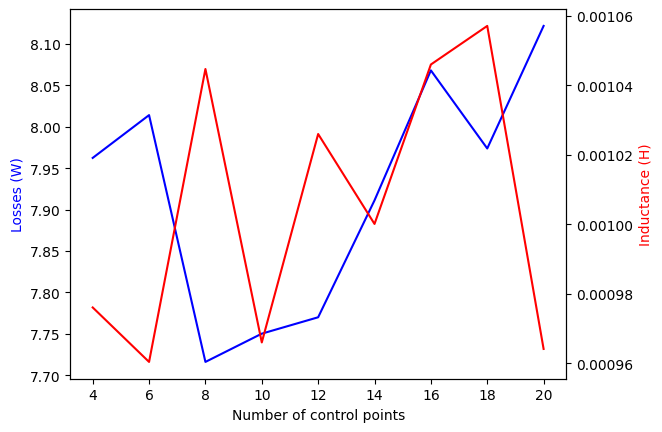

In [ ]:
InductanceListOptim = []
LossListOptim = []
for xlist in xListAll:
    meshOpt, _, _  = gen_meshN(xlist[-1])
    a = solveStateComplex(meshOpt)
    InductanceListOptim.append(Inductance(a, meshOpt))
    LossListOptim.append(Losses(a, meshOpt))

ax1 = plt.plot(NList, LossListOptim, color="b")
plt.ylabel("Losses (W)", color="b")
plt.xlabel("Number of control points")
ax2 = plt.gca().twinx()
ax2.plot(NList, InductanceListOptim, color="r")
plt.ylabel("Inductance (H)", color="r")
plt.show()



Text(0.5, 0, 'Number of control points')

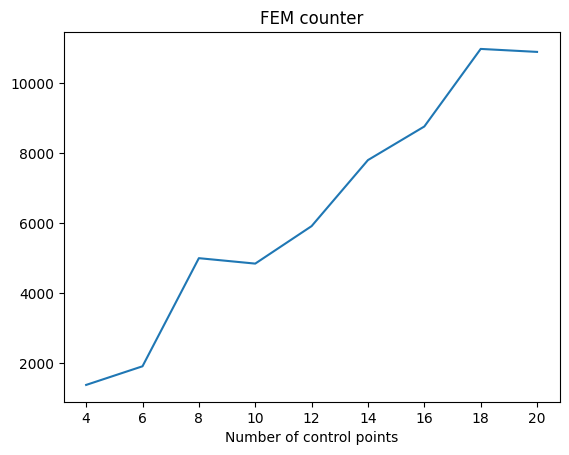

In [ ]:
plt.plot(NList, FEMcounterListAll)
plt.title("FEM counter")
plt.xlabel("Number of control points")

## Saving the results